## Importing Libraries

In [1]:
!pip install category-encoders

In [2]:
!pip install catboost

In [3]:
!pip install folium

In [4]:
!pip install joblib

In [5]:
from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import col,isnan,when,count,year, month, dayofmonth
import pandas as pd
from category_encoders.cat_boost import CatBoostEncoder
from catboost import CatBoostRegressor
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import numpy as np
import joblib
import folium
import seaborn as sns
from sklearn.model_selection import  train_test_split

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing data and EDA

In [6]:
spark = SparkSession.builder.appName('ML').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

ebird_schema = types.StructType([
        types.StructField("speciesCode",types.StringType()),
        types.StructField("comName",types.StringType()),
        types.StructField("sciName",types.StringType()),
        types.StructField("locId",types.StringType()),
        types.StructField("locName",types.StringType()),
        types.StructField("obsDt",types.DateType()),
        types.StructField("howMany",types.StringType()),
        types.StructField("lat",types.StringType()),
        types.StructField("lng",types.StringType()),
        types.StructField("obsValid",types.StringType()),
        types.StructField("obsReviewed",types.StringType()),
        types.StructField("locationPrivate",types.StringType()),
        types.StructField("subId",types.StringType()),
    ])

ebird = spark.read.format('csv').option("header","true").schema(ebird_schema).load("gs://big-data-1-project-storage/cleaned-data/ebird_nonull.csv")

In [7]:
# ebird_pandas = ebird.toPandas()

In [8]:
def feature_engineering(df):

    df = df.na.drop()
    
#     df = df.astype({'howMany': 'int64','lat':'float64','lng':'float64'})
    df = df.withColumn("howMany",df["howMany"].cast(types.IntegerType()))
    df = df.withColumn("lat",df["lat"].cast(types.FloatType()))
    df = df.withColumn("howMany",df["howMany"].cast(types.IntegerType()))
    df = df.withColumn("ObsDt",df["ObsDt"].cast(types.DateType()))
    
#     df['obsDt'] = pd.to_datetime(df['obsDt'])

    df = df.withColumn("year",year(df["obsDt"]).cast(types.IntegerType()))
    df = df.withColumn("month",month(df["obsDt"]).cast(types.IntegerType()))
    df = df.withColumn("day",dayofmonth(df["obsDt"]).cast(types.IntegerType()))
    
    print( "Count of unique bird species:  " + str(len(df.select('speciesCode').distinct().collect())))
    
    return df

In [9]:
# ebird_pandas = feature_engineering(ebird_pandas)
# ebird_pandas = ebird_pandas[["speciesCode","locId","year","month","day","howMany"]]
# ebird_pandas.head(2)

ebird_fe = feature_engineering(ebird)
ebird_fe = ebird_fe[["speciesCode","locId","year","month","day","howMany"]]
ebird_fe.show(2)

Count of unique bird species:  574
+-----------+--------+----+-----+---+-------+
|speciesCode|   locId|year|month|day|howMany|
+-----------+--------+----+-----+---+-------+
|     nswowl| L787133|2017|    3| 20|      1|
|    wilsni1|L1166559|2017|    3| 20|      1|
+-----------+--------+----+-----+---+-------+
only showing top 2 rows



In [10]:
ebird_fe.dtypes

[('speciesCode', 'string'),
 ('locId', 'string'),
 ('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('howMany', 'int')]

In [11]:
for col in [item[0] for item in ebird_fe.dtypes if item[1].startswith('int')]:
    print(ebird_fe.select(functions.skewness(col)).show(truncate=False))

+-------------------+
|skewness(year)     |
+-------------------+
|-1.0453241061535252|
+-------------------+

None
+--------------------+
|skewness(month)     |
+--------------------+
|-0.02478454189832468|
+--------------------+

None
+--------------------+
|skewness(day)       |
+--------------------+
|0.008302544227060976|
+--------------------+

None
+-----------------+
|skewness(howMany)|
+-----------------+
|86.63944575048905|
+-----------------+

None


In [12]:
for col in [item[0] for item in ebird_fe.dtypes]:
    print(str(col) + " : " + str(ebird_fe[ebird_fe[col].isNull()].count()))

speciesCode : 0
locId : 0
year : 0
month : 0
day : 0
howMany : 0


In [13]:
for cat_col in [item[0] for item in ebird_fe.dtypes if item[1].startswith('string')]:
    print(str(cat_col) + " : " + str(len(ebird_fe.select(cat_col).distinct().collect())))

speciesCode : 574
locId : 72517


In [14]:
# ebird_pandas = ebird_fe.toPandas()
# ebird_pandas_copy=ebird_pandas.select_dtypes(exclude='object').copy()

# fig = make_subplots(rows=1,cols=4,subplot_titles=(ebird_pandas_copy.columns))
# index = 0 

# for j in range(1,5):
#   plot_df=ebird_pandas_copy[ebird_pandas_copy.columns[index]]
#   trace= go.Histogram(x=plot_df)
#   fig.append_trace(trace,1,j)
#   index+=1

# fig.update_layout(width=1250,height=400,title='Distribution of Numerical Features')
# fig.show()    


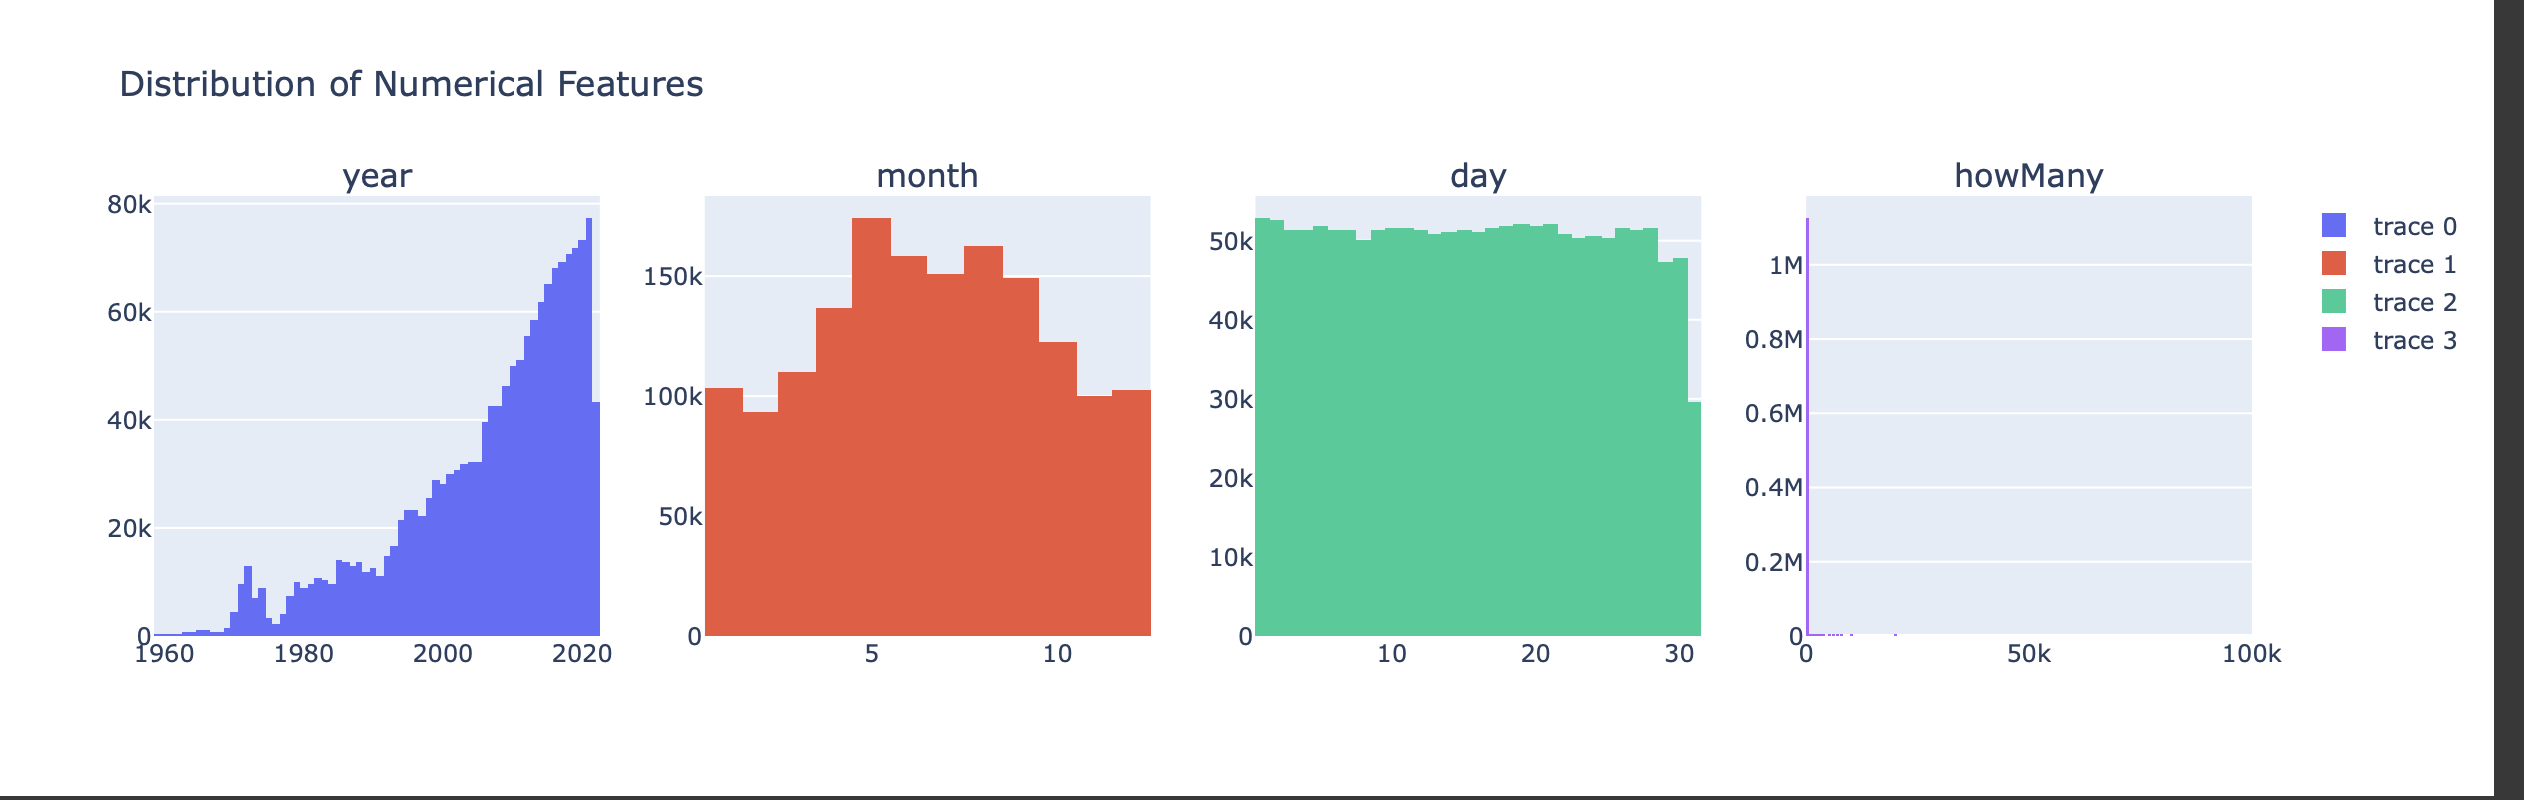

In [15]:
# fig = make_subplots(rows=1,cols=4,subplot_titles=(ebird_pandas_copy.columns))
# index = 0 

# for j in range(1,5):
#   plot_df=ebird_pandas_copy[ebird_pandas_copy.columns[index]]
#   trace= go.Box(x=plot_df)
#   fig.append_trace(trace,1,j)
#   index+=1

# fig.update_layout(width=1250,height=400,title='Distribution of Numerical Features')
# fig.show()    


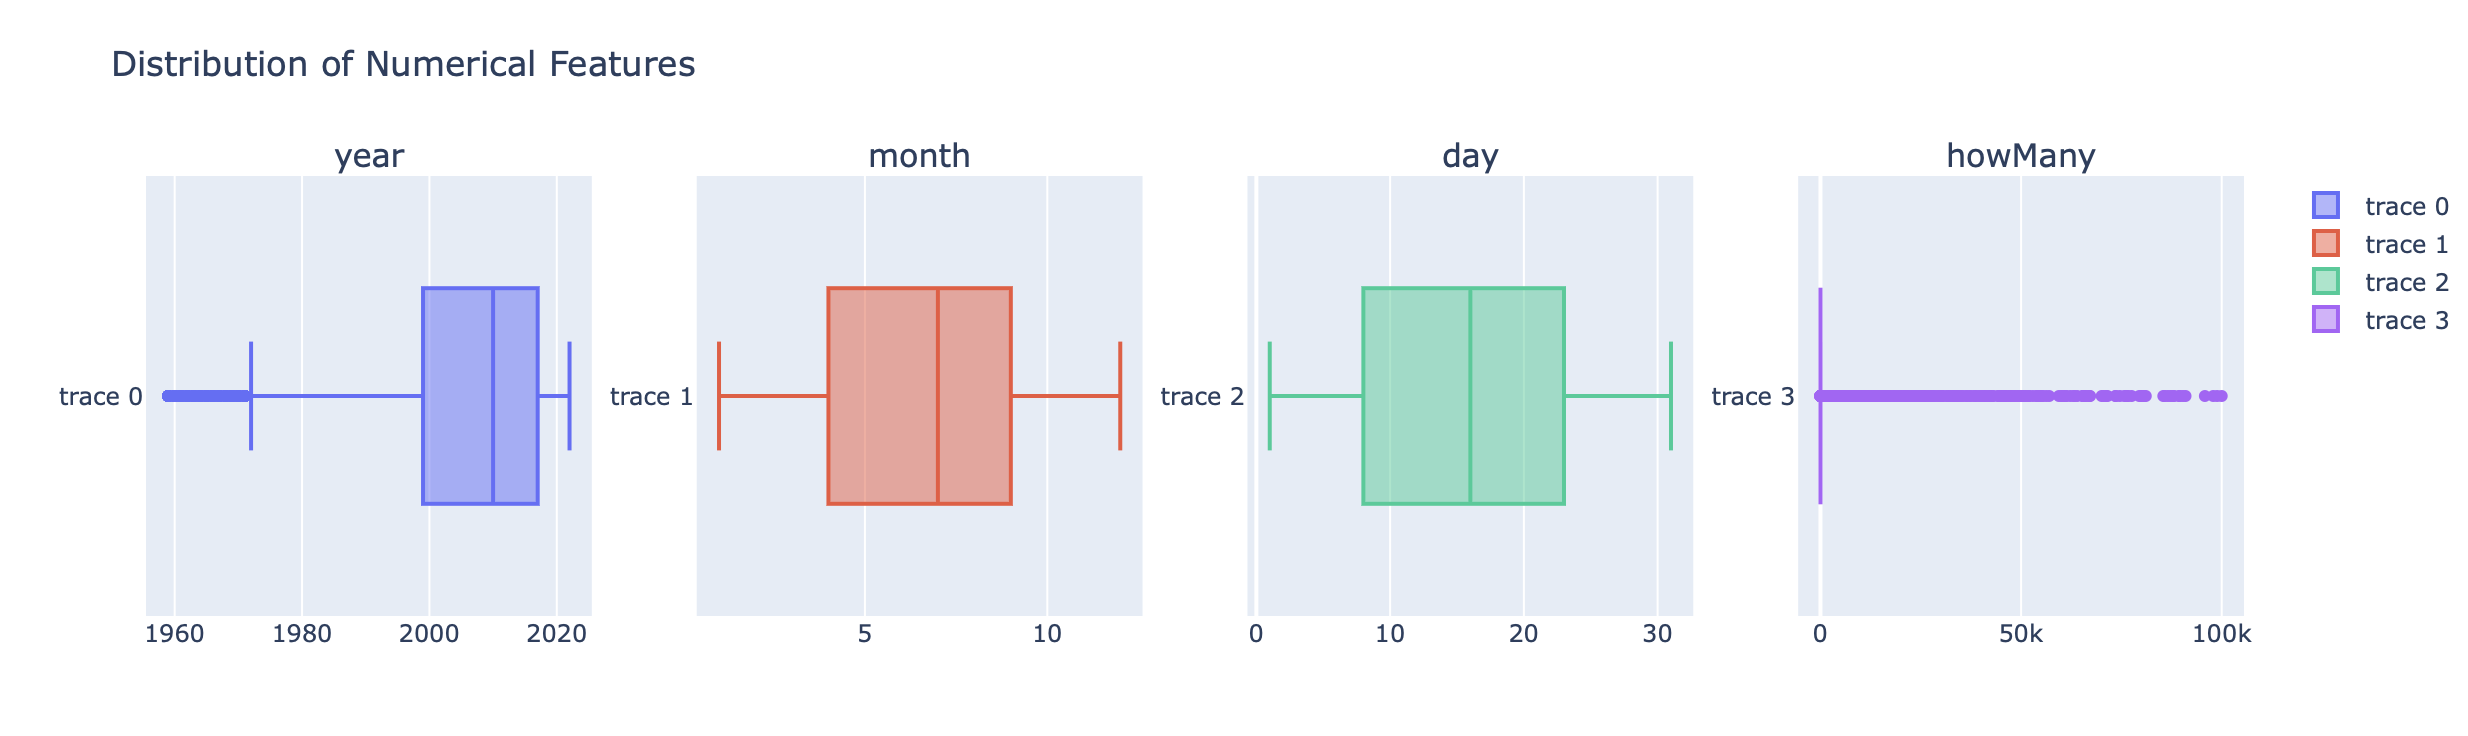

Did not consider weather data as it has too many anomalies for ML model and it was out of the scope for this project.

### Summary:

1. Data has 0 null values
2. Categorical columns present with at most 72517 categories(locId). - Need to encode these
3. "howMany" column has very high skewness (right skewed data) - Transformation needs to be done
4. Scaling needs to be done as in the boxplot you can see that all columns have different scales. - Robust scaler might be better because of presence of outliers.
5. "year" column has some outliers i.e. years from 1959 to 1971 (from boxplot). Moreover, from the histogram we can see that there are very few entries for this interval. Might make sense to ignore these years as data recording in the beginning years wouldn't be that accurate. I will also ignore 2022 as when we downloaded the dataset 2022 was still not over.


In [16]:
ebird_fe = ebird_fe.filter((ebird_fe['year']>=1972) & (ebird_fe['year']<=2021))

In [17]:
ebird_fe.filter(ebird_fe['year']==1971).show()

+-----------+-----+----+-----+---+-------+
|speciesCode|locId|year|month|day|howMany|
+-----------+-----+----+-----+---+-------+
+-----------+-----+----+-----+---+-------+



## Pyspark ML

In [46]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler,SQLTransformer,VectorIndexer,OneHotEncoder,StandardScaler
from pyspark.ml.regression import RandomForestRegressor,LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [19]:
ebird_fe.dtypes

[('speciesCode', 'string'),
 ('locId', 'string'),
 ('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('howMany', 'int')]

In [20]:
train, validation = ebird_fe.randomSplit([0.75, 0.25],seed=1)
train = train.cache()
validation = validation.cache()

In [47]:
#log transformation as howMany column is very skewed

train = train.withColumn("howMany_log",functions.log(train['howMany']))
validation = validation.withColumn("howMany_log",functions.log(validation['howMany']))

In [48]:
train = train.repartition(30)

In [49]:
train.show(1)

+-----------+--------+----+-----+---+-------+-----------+
|speciesCode|   locId|year|month|day|howMany|howMany_log|
+-----------+--------+----+-----+---+-------+-----------+
|    norhar2|L1807709|2013|    5|  1|      1|        0.0|
+-----------+--------+----+-----+---+-------+-----------+
only showing top 1 row



In [50]:
validation.show(1)

+-----------+--------+----+-----+---+-------+-----------+
|speciesCode|   locId|year|month|day|howMany|howMany_log|
+-----------+--------+----+-----+---+-------+-----------+
|     acowoo|L3171020|2014|   11| 19|      1|        0.0|
+-----------+--------+----+-----+---+-------+-----------+
only showing top 1 row



I wanted to scale the features using RobustScaler() as it is not sensitive to outliers but this is available in Spark 3.0 and we are using Spark 2.4 in our cluster since it was compatible with Jupyter notebooks. So for now I have used StandardScaler()

In [51]:
species_indexer = StringIndexer(inputCol='speciesCode', outputCol='speciesCode_indexed',handleInvalid='keep')
loc_indexer = StringIndexer(inputCol='locId', outputCol='locId_indexed',handleInvalid='keep')

# one hot encoding was increasing the dimensionality and the computation became slow so commented it

# species_ohe= OneHotEncoder(inputCol="speciesCode_indexed", 
#                      outputCol="speciesCode_encoded", 
#                      dropLast=True)

# loc_ohe= OneHotEncoder(inputCol='locId_indexed', 
#                      outputCol='locId_encdoded', 
#                      dropLast=True)

# species_featureIndexer = VectorIndexer(inputCol='vectorized_features', outputCol="indexedFeatures", 
#                                        maxCategories=4)

# featureIndexer = VectorIndexer(inputCol='vectorized_features', outputCol="indexedFeatures", maxCategories=4)

vector_assembler = VectorAssembler(inputCols=['speciesCode_indexed','locId_indexed',
                                             'year','month','day'], outputCol='vectorized_features')

scaler = StandardScaler(inputCol="vectorized_features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# regressor = RandomForestRegressor(featuresCol ='vectorized_features',
#                              labelCol = 'howMany', predictionCol = 'prediction',
#                              seed=1)

regressor = LinearRegression(featuresCol ='scaledFeatures',
                             labelCol = 'howMany_log', predictionCol = 'prediction')

rf_pipeline = Pipeline(stages=[species_indexer,
                               loc_indexer,
                               vector_assembler,
                               scaler,
                               regressor])

In [52]:
rf_model = rf_pipeline.fit(train)

In [53]:
print(rf_pipeline.params)

[Param(parent='Pipeline_f8f25f998878', name='stages', doc='a list of pipeline stages')]


In [54]:
validation_labels = rf_model.transform(validation)

In [55]:
validation_labels.show(1)

+-----------+--------+----+-----+---+-------+-----------+-------------------+-------------+--------------------+--------------------+--------------------+
|speciesCode|   locId|year|month|day|howMany|howMany_log|speciesCode_indexed|locId_indexed| vectorized_features|      scaledFeatures|          prediction|
+-----------+--------+----+-----+---+-------+-----------+-------------------+-------------+--------------------+--------------------+--------------------+
|     acowoo|L3171020|2014|   11| 19|      1|        0.0|              386.0|      59466.0|[386.0,59466.0,20...|[4.93861361729508...|-0.03972057982334576|
+-----------+--------+----+-----+---+-------+-----------+-------------------+-------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [57]:
validation_labels = validation_labels.withColumn("howMany_exp",functions.exp('prediction'))
validation_labels.show(1)

+-----------+--------+----+-----+---+-------+-----------+-------------------+-------------+--------------------+--------------------+--------------------+------------------+
|speciesCode|   locId|year|month|day|howMany|howMany_log|speciesCode_indexed|locId_indexed| vectorized_features|      scaledFeatures|          prediction|       howMany_exp|
+-----------+--------+----+-----+---+-------+-----------+-------------------+-------------+--------------------+--------------------+--------------------+------------------+
|     acowoo|L3171020|2014|   11| 19|      1|        0.0|              386.0|      59466.0|[386.0,59466.0,20...|[4.93861361729508...|-0.03972057982334576|0.9610579406177552|
+-----------+--------+----+-----+---+-------+-----------+-------------------+-------------+--------------------+--------------------+--------------------+------------------+
only showing top 1 row



In [58]:
r2_evaluator = RegressionEvaluator(metricName='r2',
                                   labelCol='howMany',
                                   predictionCol='howMany_exp'
                                   )

r2_score = validation_labels.select('howMany_exp', 'howMany')
r2_score = r2_evaluator.evaluate(r2_score)
print('R2 score on validation for LinearRegression model: %g' % (r2_score))

rmse_evaluator = RegressionEvaluator(metricName='rmse',
                                   labelCol='howMany',
                                   predictionCol='howMany_exp'
                                   )
rmse_score = validation_labels.select('howMany_exp', 'howMany')
rmse_score = rmse_evaluator.evaluate(rmse_score)
print('RMSE score on validation for LinearRegression model: %g' % (rmse_score))


R2 score on validation for LinearRegression model: -0.00131765
RMSE score on validation for LinearRegression model: 623.261


## Catboot Regressor with pandas

Just experimenting with pandas libaries as there are more ML models that you can play around with.

In [16]:
#creating independent variables as X and target/dependent variable as y
y= ebird_pandas["howMany"]
X= ebird_pandas.copy().drop(columns=["howMany"])

# Natural log and we can get the normal value using built-in numpy exp() function
# taking log of "y" as it is very skewed
y_log = np.log(y)

In [17]:
# Got best hyper parameter values using BayesSearchCV with 3-fold cross validation
# and trying to opitmize the rmse but it takes time to run on google cloud cluster 
# so I have commented it out. Found the best params and fitted final model with it

# Defining your params and training catboost on entire training set
# search_spaces = {'cat__iterations': Integer(10, 100),
#                  'cat__depth': Integer(1, 8),
#                  'cat__learning_rate': Real(0.01, 1.0, 'log-uniform'),
#                  'cat__random_strength': Real(1e-9, 10, 'log-uniform'),
#                  'cat__bagging_temperature': Real(0.0, 1.0),
#                  'cat__border_count': Integer(1, 255),
#                  'cat__l2_leaf_reg': Integer(2, 40)}

# tuned_cat=BayesSearchCV(pipeline,search_spaces,cv=3,scoring='neg_root_mean_squared_error',random_state=0)  
# tuned_cat.fit(X,y_log) 
# np.exp(-tuned_cat.best_score_)
# tuned_cat.best_params_

In [37]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y_log,test_size=0.2,random_state=0)

print("Training features shape:",X_train.shape)
print("Valid features shape:",X_valid.shape)
print("Training labels shape:",y_train.shape)
print("Valid labels shape:",y_valid.shape)

Training features shape: (1199611, 5)
Valid features shape: (299903, 5)
Training labels shape: (1199611,)
Valid labels shape: (299903,)


In [38]:
cat_encode=CatBoostEncoder(random_state=0)
rs = RobustScaler()
cat=CatBoostRegressor(random_state=0,
                     bagging_temperature=0.8866370502205778,
                      border_count=255,
                      depth=8,
                      iterations=100,
                      l2_leaf_reg=10,
                      learning_rate=0.10610085671405714,
                      random_strength=1e-09
                     )

steps = [
        ('cat_encoder',cat_encode),
         ('scaler',rs),
         ('cat',cat)]
           
pipeline = Pipeline(steps=steps)

In [39]:
pipeline.fit(X_train,y_train)

0:	learn: 1.2652829	total: 48.5ms	remaining: 4.8s
1:	learn: 1.2295021	total: 86.4ms	remaining: 4.23s
2:	learn: 1.1997910	total: 119ms	remaining: 3.83s
3:	learn: 1.1750876	total: 157ms	remaining: 3.76s
4:	learn: 1.1543022	total: 188ms	remaining: 3.57s
5:	learn: 1.1371551	total: 223ms	remaining: 3.49s
6:	learn: 1.1229229	total: 261ms	remaining: 3.46s
7:	learn: 1.1112406	total: 295ms	remaining: 3.39s
8:	learn: 1.1013447	total: 330ms	remaining: 3.33s
9:	learn: 1.0933116	total: 369ms	remaining: 3.32s
10:	learn: 1.0863115	total: 403ms	remaining: 3.26s
11:	learn: 1.0803112	total: 438ms	remaining: 3.21s
12:	learn: 1.0756096	total: 475ms	remaining: 3.18s
13:	learn: 1.0716089	total: 509ms	remaining: 3.13s
14:	learn: 1.0681122	total: 545ms	remaining: 3.09s
15:	learn: 1.0650857	total: 582ms	remaining: 3.06s
16:	learn: 1.0626894	total: 616ms	remaining: 3s
17:	learn: 1.0605049	total: 651ms	remaining: 2.96s
18:	learn: 1.0587948	total: 684ms	remaining: 2.91s
19:	learn: 1.0571517	total: 716ms	remaining

Pipeline(memory=None,
         steps=[('cat_encoder',
                 CatBoostEncoder(a=1, cols=['speciesCode', 'locId'],
                                 drop_invariant=False, handle_missing='value',
                                 handle_unknown='value', random_state=0,
                                 return_df=True, sigma=None, verbose=0)),
                ('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('cat',
                 <catboost.core.CatBoostRegressor object at 0x7f9cc426c390>)],
         verbose=False)

In [40]:
predicted = np.exp(pipeline.predict(X_valid))
X_valid["Forecast"] = predicted

/opt/conda/anaconda/bin/ipython:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(np.exp(y_valid), predicted)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 680.148297


In [43]:
X_valid

,speciesCode,locId,year,month,day,Forecast
1043313,naswar,L1810768,2019,5,29,1.405876
927257,casauk,L16281531,2021,9,2,2.208270
124296,rhiauk,L311854,2016,1,25,5.172159
616841,bnhcow,L1525650,2012,10,2,2.100980
894728,ribgul,L2225130,2021,5,24,4.031866
...,...,...,...,...,...,...
1029964,rhiauk,L8819353,2019,3,9,4.804920
27640,ribgul,L303524,2017,10,16,5.673278
150284,batpig1,L2720806,2015,5,11,2.038279
1482824,stejay,L354249,1978,10,15,2.224569


In [44]:
y_valid

1043313    0.000000
927257     2.708050
124296     1.609438
616841     1.791759
894728     2.302585
             ...   
1029964    0.693147
27640      1.791759
150284     1.098612
1482824    0.693147
836630     0.000000
Name: howMany, Length: 299903, dtype: float64